In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TrafficsignsRecognition

Mounted at /content/drive
/content/drive/MyDrive/TrafficsignsRecognition


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow import keras as kr
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [ ]:
labels_f = pd.read_csv('labels2.csv', delimiter=';', header=None)

categories = np.array(labels_f.iloc[:, 0])
decriptions = np.array(labels_f.iloc[:, 1])
print(categories)

['DP.135' 'EMPTY' 'P.102' 'P.103a' 'P.103b' 'P.115' 'P.116' 'P.117'
 'P.121' 'P.122' 'P.123a' 'P.123b' 'P.124a' 'P.124b' 'P.124c' 'P.124e'
 'P.125' 'P.127' 'P.130' 'P.131a' 'R.302a' 'R.303' 'R.420' 'R.421'
 'W.201a' 'W.201b' 'W.202a' 'W.202b' 'W.203a' 'W.203c' 'W.205a' 'W.205b'
 'W.205c' 'W.205d' 'W.207a' 'W.207b' 'W.207c' 'W.208' 'W.209' 'W.221b'
 'W.224' 'W.225' 'W.227' 'W.235' 'W.236' 'W.239' 'W.240' 'W.245a']


In [ ]:
def loadData(path):
  with open(path, 'rb') as file:
    # Load images from data file
    (pixels, label_ids) = pickle.load(file)
    file.close()
  print('Check shape of images and label_ids')
  print(pixels.shape)
  print(label_ids.shape)

  return pixels, label_ids

In [ ]:
images, labels = loadData('data.data')

In [ ]:
trainX, testx, trainY, testy = train_test_split(images, labels, test_size=0.1, random_state=42)
trainx, validx, trainy, validy = train_test_split(trainX, trainY, test_size=0.15, random_state=42)

trainY = kr.utils.to_categorical(trainy, len(categories))

print(trainx.shape)
print(trainy.shape)
print(validx.shape)
print(validy.shape)
print(testx.shape)
print(testy.shape)

(11245, 224, 224, 3)
(11245, 48)
(1985, 224, 224, 3)
(1985, 48)
(1470, 224, 224, 3)
(1470, 48)


In [ ]:
HEIGHT = 256
WIDTH = 256
N_CHANNELS = 3
EPOCHS = 200
INIT_LR = 1e-3
BS = 32

class_names = categories

mobilenet = kr.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)
for layer in mobilenet.layers:
  layer.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation='softmax'))

opt = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [ ]:
class CustomCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
    accuracy = logs.get('accuracy')
    if accuracy and accuracy >= 0.92:
      print(f'\nStopping training as accuracy has reached {accuracy * 100:.2f}%')
      self.model.stop_training = True

earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    verbose=1,
    restore_best_weights=True
)
custom_callback = CustomCallback()

In [ ]:
model.fit(
    trainx,
    trainy,
    validation_data=(validx, validy),
    batch_size=BS,
    epochs=EPOCHS,
    callbacks=[earlystop, custom_callback]
)

Epoch 1/200
352/352 [==============================] - 24s 46ms/step - loss: 3.1478 - accuracy: 0.1835 - val_loss: 1.5082 - val_accuracy: 0.5909
Epoch 2/200
352/352 [==============================] - 15s 41ms/step - loss: 1.7450 - accuracy: 0.4759 - val_loss: 0.8849 - val_accuracy: 0.7300
Epoch 3/200
352/352 [==============================] - 14s 41ms/step - loss: 1.2887 - accuracy: 0.5991 - val_loss: 0.6821 - val_accuracy: 0.7778
Epoch 4/200
352/352 [==============================] - 14s 41ms/step - loss: 1.0562 - accuracy: 0.6676 - val_loss: 0.5130 - val_accuracy: 0.8685
Epoch 5/200
352/352 [==============================] - 14s 41ms/step - loss: 0.9111 - accuracy: 0.7160 - val_loss: 0.4271 - val_accuracy: 0.8690
Epoch 6/200
352/352 [==============================] - 15s 42ms/step - loss: 0.8038 - accuracy: 0.7531 - val_loss: 0.3501 - val_accuracy: 0.9033
Epoch 7/200
352/352 [==============================] - 15s 43ms/step - loss: 0.7248 - accuracy: 0.7755 - val_loss: 0.3119 - val_ac

In [ ]:
model.save('mobilenet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pred = model.predict(testx)
predictions = np.argmax(pred, axis=1) # return to label
ytest = list(map(lambda x: np.argmax(x), testy))

accuracy = accuracy_score(ytest, predictions)
print("Accuracy : %.2f%%" % (accuracy*100.0))

prec, rec, f1, _ = precision_recall_fscore_support(ytest, predictions)
print(f'Precision: {round((np.average(prec) * 100), 2)}')
print(f'Recall: {round((np.average(rec) * 100), 2)}')
print(f'F1: {round((np.average(f1) * 100), 2)}')

46/46 [==============================] - 3s 52ms/step
Accuracy : 96.46%
Precision: 96.5
Recall: 96.48
F1: 96.41


1/1 [==============================] - 0s 34ms/step


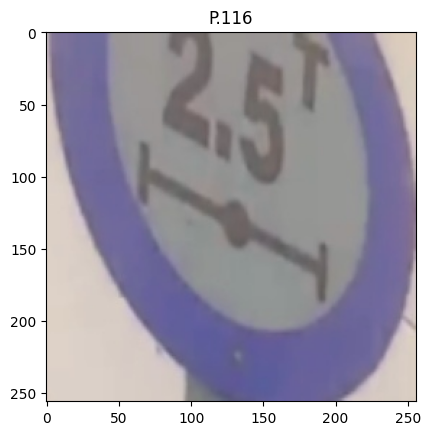

In [ ]:

image = cv2.imread('vd10_16860.jpg')
img = cv2.resize(image, (224, 224))
img = np.expand_dims(img, axis=0)
img = kr.applications.mobilenet.preprocess_input(img)
predict = model.predict([img])
label_id = np.argmax(predict, axis=1)
label = categories[label_id[0]]

plt.imshow(image)
plt.title(label)
plt.show()